# Live Human Pose Estimation with OpenVINO

This notebook demonstrates live pose estimation with OpenVINO. We use the OpenPose model [human-pose-estimation-0001](https://github.com/openvinotoolkit/open_model_zoo/tree/master/models/intel/human-pose-estimation-0001) from [Open Model Zoo](https://github.com/openvinotoolkit/open_model_zoo/). At the bottom of this notebook, you will see live inference results from your webcam. You can also upload a video file.

> NOTE: _To use the webcam, you must run this Jupyter notebook on a computer with a webcam. If you run on a server, the webcam will not work. However, you can still do inference on a video in the final step._

## Imports

In [1]:
import collections
import os
import sys
import time

import cv2
import numpy as np
from IPython import display
from numpy.lib.stride_tricks import as_strided
from openvino.runtime import Core

from decoder import OpenPoseDecoder

sys.path.append("utils")
import notebook_utils as utils

## The model

### Download the model

We use `omz_downloader`, which is a command line tool from the `openvino-dev` package. `omz_downloader` automatically creates a directory structure and downloads the selected model.

If you want to download another model, please change the model name and precision. *Note: This will require a different pose decoder*.

In [3]:
# directory where model will be downloaded
base_model_dir = "model"

# model name as named in Open Model Zoo
model_name = "human-pose-estimation-0001"
# selected precision (FP32, FP16, FP16-INT8)
precision = "FP16-INT8"

model_path = f"model/intel/{model_name}/{precision}/{model_name}.xml"
model_weights_path = f"model/intel/{model_name}/{precision}/{model_name}.bin"

if not os.path.exists(model_path):
    download_command = f"omz_downloader " \
                       f"--name {model_name} " \
                       f"--precision {precision} " \
                       f"--output_dir {base_model_dir}"
    ! $download_command

### Load the model

Downloaded models are located in a fixed structure, which indicates vendor, model name and precision.

Only a few lines of code are required to run the model. First, we initialize the Inference Engine. Then we read the network architecture and model weights from the .bin and .xml files to compile it for the desired device.

In [4]:
# initialize inference engine
ie_core = Core()
# read the network and corresponding weights from file
model = ie_core.read_model(model=model_path, weights=model_weights_path)
# load the model on the CPU (you can use GPU or MYRIAD as well)
compiled_model = ie_core.compile_model(model=model, device_name="CPU")

# get input and output names of nodes
input_layer = compiled_model.input(0)
output_layers = list(compiled_model.outputs)

# get input size
height, width = list(input_layer.shape)[2:]

Input layer has the name of the input node and output layers contain names of output nodes of the network. In the case of the OpenPose Model, we have one input and two outputs: pafs and keypoints heatmap.

In [5]:
input_layer.any_name, [o.any_name for o in output_layers]

('data', ['Mconv7_stage2_L1', 'Mconv7_stage2_L2'])

## Processing

### OpenPoseDecoder

We need a decoder to transform the raw results from the neural network into pose estimations. This magic happens inside Open Pose Decoder, which is provided in the [Open Model Zoo](https://github.com/openvinotoolkit/open_model_zoo/blob/master/demos/common/python/openvino/model_zoo/model_api/models/open_pose.py) and compatible with the `human-pose-estimation-0001` model.

If you choose a model other than `human-pose-estimation-0001` you will need another decoder (e.g. AssociativeEmbeddingDecoder), which is available in the [demos section](https://github.com/openvinotoolkit/open_model_zoo/blob/master/demos/common/python/openvino/model_zoo/model_api/models/hpe_associative_embedding.py) of Open Model Zoo.

In [6]:
decoder = OpenPoseDecoder()

### Process Results

A bunch of useful functions to transform results into poses.

First, we will pool the heatmap. Since pooling is not available in numpy, we use a simple method to do it directly with numpy. Then, we use non-maximum suppression to get the keypoints from the heatmap. After that, we decode poses using the decoder. Since the input image is bigger than the network outputs, we need to multiply all pose coordinates by a scaling factor.

In [7]:
# 2d pooling in numpy (from: htt11ps://stackoverflow.com/a/54966908/1624463)
def pool2d(A, kernel_size, stride, padding, pool_mode="max"):
    """
    2D Pooling

    Parameters:
        A: input 2D array
        kernel_size: int, the size of the window
        stride: int, the stride of the window
        padding: int, implicit zero paddings on both sides of the input
        pool_mode: string, 'max' or 'avg'
    """
    # Padding
    A = np.pad(A, padding, mode="constant")

    # Window view of A
    output_shape = (
        (A.shape[0] - kernel_size) // stride + 1,
        (A.shape[1] - kernel_size) // stride + 1,
    )
    kernel_size = (kernel_size, kernel_size)
    A_w = as_strided(
        A,
        shape=output_shape + kernel_size,
        strides=(stride * A.strides[0], stride * A.strides[1]) + A.strides
    )
    A_w = A_w.reshape(-1, *kernel_size)

    # Return the result of pooling
    if pool_mode == "max":
        return A_w.max(axis=(1, 2)).reshape(output_shape)
    elif pool_mode == "avg":
        return A_w.mean(axis=(1, 2)).reshape(output_shape)


# non maximum suppression
def heatmap_nms(heatmaps, pooled_heatmaps):
    return heatmaps * (heatmaps == pooled_heatmaps)


# get poses from results
def process_results(img, pafs, heatmaps):
    # this processing comes from
    # https://github.com/openvinotoolkit/open_model_zoo/blob/master/demos/common/python/models/open_pose.py
    pooled_heatmaps = np.array(
        [[pool2d(h, kernel_size=3, stride=1, padding=1, pool_mode="max") for h in heatmaps[0]]]
    )
    nms_heatmaps = heatmap_nms(heatmaps, pooled_heatmaps)

    # decode poses
    poses, scores = decoder(heatmaps, nms_heatmaps, pafs)
    output_shape = list(compiled_model.output(index=0).partial_shape)
    output_scale = img.shape[1] / output_shape[3].get_length(), img.shape[0] / output_shape[2].get_length()
    # multiply coordinates by scaling factor
    poses[:, :, :2] *= output_scale
    return poses, scores

### Draw Pose Overlays

Draw pose overlays on the image to visualize estimated poses. Joints are drawn as circles and limbs are drawn as lines. The code is based on the [Human Pose Estimation Demo](https://github.com/openvinotoolkit/open_model_zoo/tree/master/demos/human_pose_estimation_demo/python) from Open Model Zoo.

In [8]:
colors = ((255, 0, 0), (255, 0, 255), (170, 0, 255), (255, 0, 85), (255, 0, 170), (85, 255, 0),
          (255, 170, 0), (0, 255, 0), (255, 255, 0), (0, 255, 85), (170, 255, 0), (0, 85, 255),
          (0, 255, 170), (0, 0, 255), (0, 255, 255), (85, 0, 255), (0, 170, 255))

default_skeleton = ((15, 13), (13, 11), (16, 14), (14, 12), (11, 12), (5, 11), (6, 12), (5, 6), (5, 7),
                    (6, 8), (7, 9), (8, 10), (1, 2), (0, 1), (0, 2), (1, 3), (2, 4), (3, 5), (4, 6))


def draw_poses(img, poses, point_score_threshold, skeleton=default_skeleton):
    if poses.size == 0:
        return img

    img_limbs = np.copy(img)
    for pose in poses:
        points = pose[:, :2].astype(np.int32)
        points_scores = pose[:, 2]
        # Draw joints.
        for i, (p, v) in enumerate(zip(points, points_scores)):
            if v > point_score_threshold:
                cv2.circle(img, tuple(p), 1, colors[i], 2)
        # Draw limbs.
        for i, j in skeleton:
            if points_scores[i] > point_score_threshold and points_scores[j] > point_score_threshold:
                cv2.line(img_limbs, tuple(points[i]), tuple(points[j]), color=colors[j], thickness=4)
    cv2.addWeighted(img, 0.4, img_limbs, 0.6, 0, dst=img)
    return img

### Main Processing Function

Run pose estimation on the specified source. Either a webcam or a video file.

In [9]:
# main processing function to run pose estimation
def run_pose_estimation(source=0, flip=False, use_popup=False, skip_first_frames=0):
    pafs_output_key = compiled_model.output("Mconv7_stage2_L1")
    heatmaps_output_key = compiled_model.output("Mconv7_stage2_L2")
    player = None
    try:
        # create video player to play with target fps
        player = utils.VideoPlayer(source, flip=flip, fps=30, skip_first_frames=skip_first_frames)
        # start capturing
        player.start()
        if use_popup:
            title = "Press ESC to Exit"
            cv2.namedWindow(title, cv2.WINDOW_GUI_NORMAL | cv2.WINDOW_AUTOSIZE)

        processing_times = collections.deque()

        while True:
            # grab the frame
            frame = player.next()
            if frame is None:
                print("Source ended")
                break
            # if frame larger than full HD, reduce size to improve the performance
            scale = 1280 / max(frame.shape)
            if scale < 1:
                frame = cv2.resize(frame, None, fx=scale, fy=scale, interpolation=cv2.INTER_AREA)

            # resize image and change dims to fit neural network input
            # (see https://github.com/openvinotoolkit/open_model_zoo/tree/master/models/intel/human-pose-estimation-0001)
            input_img = cv2.resize(frame, (width, height), interpolation=cv2.INTER_AREA)
            # create batch of images (size = 1)
            input_img = input_img.transpose((2,0,1))[np.newaxis, ...]

            # measure processing time
            start_time = time.time()
            # get results
            results = compiled_model([input_img])
            stop_time = time.time()

            pafs = results[pafs_output_key]
            heatmaps = results[heatmaps_output_key]
            # get poses from network results
            poses, scores = process_results(frame, pafs, heatmaps)

            # draw poses on a frame
            frame = draw_poses(frame, poses, 0.1)

            processing_times.append(stop_time - start_time)
            # use processing times from last 200 frames
            if len(processing_times) > 200:
                processing_times.popleft()

            _, f_width = frame.shape[:2]
            # mean processing time [ms]
            processing_time = np.mean(processing_times) * 1000
            fps = 1000 / processing_time
            cv2.putText(frame, f"Inference time: {processing_time:.1f}ms ({fps:.1f} FPS)", (20, 40),
                        cv2.FONT_HERSHEY_COMPLEX, f_width / 1000, (0, 0, 255), 1, cv2.LINE_AA)

            # use this workaround if there is flickering
            if use_popup:
                cv2.imshow(title, frame)
                key = cv2.waitKey(1)
                # escape = 27
                if key == 27:
                    break
            else:
                # encode numpy array to jpg
                _, encoded_img = cv2.imencode(".jpg", frame, params=[cv2.IMWRITE_JPEG_QUALITY, 90])
                # create IPython image
                i = display.Image(data=encoded_img)
                # display the image in this notebook
                display.clear_output(wait=True)
                display.display(i)
    # ctrl-c
    except KeyboardInterrupt:
        print("Interrupted")
    # any different error
    except RuntimeError as e:
        print(e)
    finally:
        if player is not None:
            # stop capturing
            player.stop()
        if use_popup:
            cv2.destroyAllWindows()

## Run

### Run Live Pose Estimation

Run using a webcam as the video input. By default, the primary webcam is set with `source=0`. If you have multiple webcams, each one will be assigned a consecutive number starting at 0. Set `flip=True` when using a front-facing camera. Some web browsers, especially Mozilla Firefox, may cause flickering. If you experience flickering, set `use_popup=True`.

*Note: To use this notebook with a webcam, you need to run the notebook on a computer with a webcam. If you run the notebook on a server (e.g. Binder), the webcam will not work.*

*Note: Popup mode may not work if you run this notebook on a remote computer (e.g. Binder).*

In [11]:
run_pose_estimation(source=0, flip=True, use_popup=True)

Interrupted


### Run Pose Estimation on a Video File

If you don't have a webcam, you can still run this demo with a video file. Any [format supported by OpenCV](https://docs.opencv.org/4.5.1/dd/d43/tutorial_py_video_display.html) will work. You can skip first N frames to fast forward video.

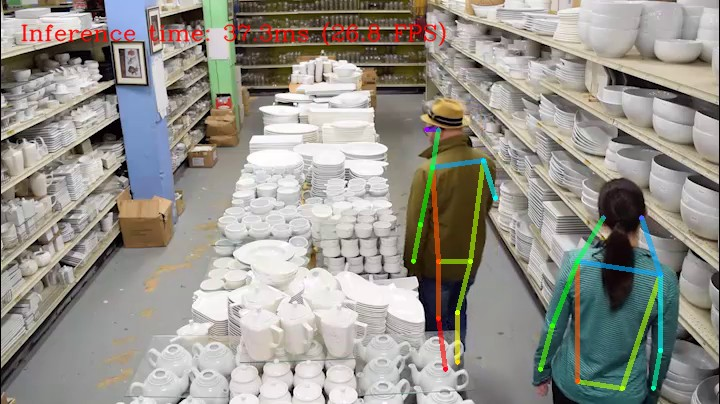

Interrupted


In [12]:
video_file = "https://github.com/intel-iot-devkit/sample-videos/blob/master/store-aisle-detection.mp4?raw=true"

run_pose_estimation(video_file, flip=False, use_popup=False, skip_first_frames=500)